## Importing, time stepping, and grid spacing

In [48]:
import numpy as np
import climlab # package used for calculating orbital parameters overtime
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
import matplotlib.pyplot as plt


#timesteping 
t_i = 0
t_f = -700000 #run model for the past 700,000 years 
d_t = 100 #use time step of 100 years
t = np.arange(t_f, t_i+1, 100)
t_kyr = (t/(1000)) # years in kyr, needed to calculate orbital parameters

#grid spacing
x_i = 0 # corresponds to 74 degrees N latitute (northern boundary) 
x_f = 4889000 # corresponds to 30 degrees N latitude (southern boundary)
x = np.linspace(x_i, x_f, 100)
d_x = x_f/(len(x)-1)

[      0.           49383.83838384   98767.67676768  148151.51515152
  197535.35353535  246919.19191919  296303.03030303  345686.86868687
  395070.70707071  444454.54545455  493838.38383838  543222.22222222
  592606.06060606  641989.8989899   691373.73737374  740757.57575758
  790141.41414141  839525.25252525  888909.09090909  938292.92929293
  987676.76767677 1037060.60606061 1086444.44444444 1135828.28282828
 1185212.12121212 1234595.95959596 1283979.7979798  1333363.63636364
 1382747.47474747 1432131.31313131 1481515.15151515 1530898.98989899
 1580282.82828283 1629666.66666667 1679050.50505051 1728434.34343434
 1777818.18181818 1827202.02020202 1876585.85858586 1925969.6969697
 1975353.53535354 2024737.37373737 2074121.21212121 2123505.05050505
 2172888.88888889 2222272.72727273 2271656.56565657 2321040.4040404
 2370424.24242424 2419808.08080808 2469191.91919192 2518575.75757576
 2567959.5959596  2617343.43434343 2666727.27272727 2716111.11111111
 2765494.94949495 2814878.78787879 2

## Calculating orbital parameters

Slight changes in the Earth's orbit cause different level of insolation over long time periods. These changes happen at regular frequencies and directly influence glacial melt and snow accumulation

In [32]:
days = np.linspace(1,365.24, 365)/365 * 365.24
orb = OrbitalTable.interp(kyear=t_kyr ) #calculate orbital parameters for past 700,000 years, every 100 years

Q = daily_insolation(x, days, orb) #calculate daily insolation per every 500 years based on orbit parameters


The net annual mass balance on the ice sheet suface, depending on snowfall and ice melt, is given by
$$ G = \begin{cases}
a(h+h' -E) - b(h+h'-E)^2 & h+h' - E \leq 1500 \text{ m} \\
0.56 & h+h' - E > 1500 \text{ m}
\end{cases} \text{     m yr}^{-1} $$
where $E$ is defined 
$$E = E_0(x) + k \Delta Q$$
$E_0(x)$: the present equlibrium line<br>
$k$: insolation sensitivity <br>
$\Delta Q$: is the difference in the summer half-year insolation at $55 \degree$ N from that of the present <br>

**To calculate $\Delta Q:$** <br>
The summer half-year insolation is represents the amount of insolation integrated over the caloric summer half of the year, defined such that any day of the summer half receives more insolation than any day of the winter half (Milankovitch, 1941; Berger, 1978). We need to calculate this at each latitute for ever time step, and subtract the summer half-year insolation at $55 \degree$ N. 



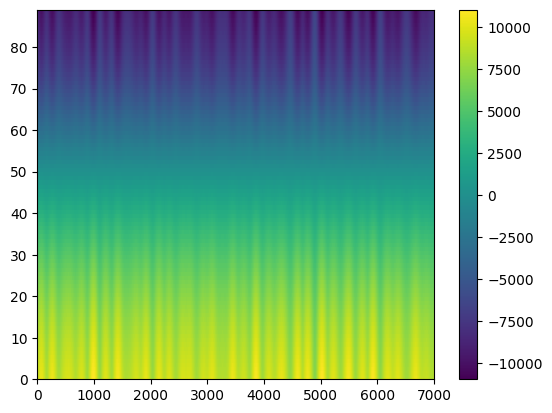

In [33]:
#to calculate summer half year insolation, we first need to find the upper half of the daily insolations
# we do this by splitting the data by the along median, then adding the remaining values 

delta_Q = np.zeros((len(x), len(t_kyr)))

for i in range(len(t_kyr)):
    daily_55 = Q[50, :, i]
    median_insolation_55 = np.median(daily_55)
    summer_total_55 = sum(daily_55[daily_55>median_insolation_55])
    for j in range(len(x)):
        daily = Q[j,:, i]
        median_insolation = np.median(daily)
        summer_total = sum(daily[daily> median_insolation])
        #now need to subtract the 55 degree N summer half year from each latitute to find delta Q
        delta_Q[j, i] = summer_total - summer_total_55


plt.figure()
plt.pcolor(delta_Q)
plt.colorbar()


In [34]:
# now we need to calculate E0 the present equilibrium line
def E0(x):
    return (9e-4 * x) - (6.57e-2)

#now we can combine E0 and delta_Q
k = 25 #insolation sensitivity, meter light-years^-1 day
def E(x, t):
    return E0(x) + k * delta_Q[x,t] #might have to change indexing later

#Finally we define G, the nonlinear term of the diffusion equation 
a = 0.81e-3 #years^-1
b = 0.3e-6 #meters^-3 years^-1
def G(x, t, h):
    if (h - E(x,t) <= 1500):
        return a*(h-E) - b*(h-E)**2
    else:
        return 0.56



### Boundary and Initial Conditions
For the initial height of the ice sheet we assume a rectangular cross section with a height of 920.43 meters. <br>
The boundary conditions for the southern boundary is that the height is zero (Dirichlet) <br>
For the northern boundary there is a no flux boundary condition


In [53]:
# Parameters
A = 5.77e-4 #meters^-3 years^-1
alpha = 5
beta = 2

# Initialize glacier 
#want to the northern part of glacier to be 920 m and decrease moving south so the southern border is 0 m
h_ini = np.linspace(920, 0, len(x))

# Initialize Matrix
P = np.zeros((len(h_ini), len(t)))


    





(100, 7001)
